In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV,cross_val_score, learning_curve, validation_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
%matplotlib inline

In [110]:
atp_data = pd.read_pickle("./atp_cleaned_data.pkl")
atp_data.head()

,draw_size,match_num,player_id,player_seed,player_height,player_age,best_of,minutes,ace,double_fault,...,round_br,round_er,round_f,round_qf,round_r128,round_r16,round_r32,round_r64,round_rr,round_sf
0,32,1,103163,1.0,188.0,21.771389,3,108.0,18.0,4.0,...,0,0,0,0,0,0,1,0,0,0
1,32,2,102607,999.0,190.0,24.558522,3,85.0,5.0,3.0,...,0,0,0,0,0,0,1,0,0,0
2,32,3,103252,999.0,175.0,21.390828,3,56.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
3,32,4,103507,7.0,183.0,19.909651,3,68.0,5.0,1.0,...,0,0,0,0,0,0,1,0,0,0
4,32,5,102103,999.0,180.0,27.381246,3,115.0,1.0,2.0,...,0,0,0,0,0,0,1,0,0,0


In [112]:
mask = atp_data["french_open_2020"] == 1
atp_french_open_2020 = atp_data[mask]
atp_french_open_2020 = atp_french_open_2020.reset_index(drop=True)

In [113]:
#atp_data = atp_data.drop(atp_data[mask], axis =0)
#index_names  = atp_data[mask].index
#index_names

In [114]:
atp_data = atp_data[atp_data["french_open_2020"] == 0]
atp_data.shape
#(128070, 46)

(127816, 46)

In [115]:
atp_data = atp_data.reset_index(drop = True)


In [118]:
atp_data.head()

,draw_size,match_num,player_id,player_seed,player_height,player_age,best_of,minutes,ace,double_fault,...,round_br,round_er,round_f,round_qf,round_r128,round_r16,round_r32,round_r64,round_rr,round_sf
0,32,1,103163,1.0,188.0,21.771389,3,108.0,18.0,4.0,...,0,0,0,0,0,0,1,0,0,0
1,32,2,102607,999.0,190.0,24.558522,3,85.0,5.0,3.0,...,0,0,0,0,0,0,1,0,0,0
2,32,3,103252,999.0,175.0,21.390828,3,56.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
3,32,4,103507,7.0,183.0,19.909651,3,68.0,5.0,1.0,...,0,0,0,0,0,0,1,0,0,0
4,32,5,102103,999.0,180.0,27.381246,3,115.0,1.0,2.0,...,0,0,0,0,0,0,1,0,0,0


In [119]:
atp_data.shape


(127816, 46)

In [120]:
atp_data.describe()

,draw_size,match_num,player_id,player_seed,player_height,player_age,best_of,minutes,ace,double_fault,...,round_br,round_er,round_f,round_qf,round_r128,round_r16,round_r32,round_r64,round_rr,round_sf
count,127816.000000,127816.000000,127816.000000,127816.000000,127816.000000,127816.000000,127816.000000,127816.000000,127816.000000,127816.000000,...,127816.000000,127816.000000,127816.000000,127816.000000,127816.000000,127816.000000,127816.000000,127816.000000,127816.000000,127816.000000
mean,54.149465,76.398072,105678.255594,681.176152,185.490569,26.351251,3.461726,114.663625,22.846601,20.143144,...,0.000094,0.000501,0.022094,0.085248,0.101646,0.169619,0.316564,0.151922,0.108938,0.043375
std,39.375071,114.075044,10045.990462,462.616497,6.457546,4.591277,0.842773,46.277051,52.585726,53.264402,...,0.009689,0.022371,0.146991,0.279251,0.302184,0.375299,0.465138,0.358946,0.311562,0.203700
min,4.000000,1.000000,100644.000000,1.000000,163.000000,14.513347,3.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,10.000000,103344.000000,11.000000,183.000000,23.411362,3.000000,78.000000,3.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,32.000000,25.000000,104198.000000,999.000000,185.000000,26.195756,3.000000,105.000000,5.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,64.000000,86.000000,105015.000000,999.000000,188.000000,29.048597,3.000000,144.000000,10.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,128.000000,1701.000000,210013.000000,999.000000,208.000000,185.490424,5.000000,1266.000000,185.490424,185.490424,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**check for missing values**

In [121]:
#Total missing values
atp_data.isnull().sum().sum()

0

In [122]:
# Random Seed
SEED = 42
np.random.seed = SEED

**check if the data is balance**
target is our target variable, we want to make sure the data is balanced

In [123]:
#check if the data is balance
atp_data['target'].value_counts()

1    63908
0    63908
Name: target, dtype: int64

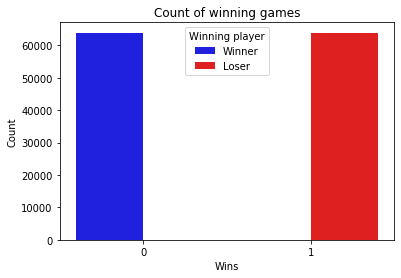

In [124]:
ax = sns.countplot(atp_data['target'], hue=atp_data['target'], palette=['blue', 'red'])
ax.set(xlabel='Wins', ylabel='Count')
ax.legend(title='Winning player', loc='upper center', labels=['Winner', 'Loser'])
ax.set_title('Count of winning games')
plt.show()

**Checking correlation between features**

In [125]:
atp_corr = atp_data.corr()
atp_corr['target'].sort_values(ascending=False)

target                1.000000e+00
player_rank_points    1.915739e-01
first_serve_won       3.829016e-02
player_height         3.176903e-02
player_hand_r         2.648346e-02
ace                   1.561996e-02
second_serve_won      1.539065e-02
serve_game            1.832305e-03
year                  2.777489e-17
surface_clay          1.260510e-18
round_r64             8.372853e-19
surface_carpet        7.514471e-19
round_rr              7.367101e-19
round_sf              4.269506e-19
tourney_level_m       2.648055e-19
round_er              2.463861e-19
tourney_level_a       2.287163e-19
day                   1.700964e-19
best_of               1.607831e-19
round_r16             1.515970e-19
tourney_level_g       1.123425e-19
surface_grass         7.011914e-20
round_br              1.597755e-21
round_f              -3.102388e-20
round_r32            -7.843221e-20
month                -2.013799e-19
round_r128           -2.781038e-19
minutes              -2.907076e-19
tourney_level_f     

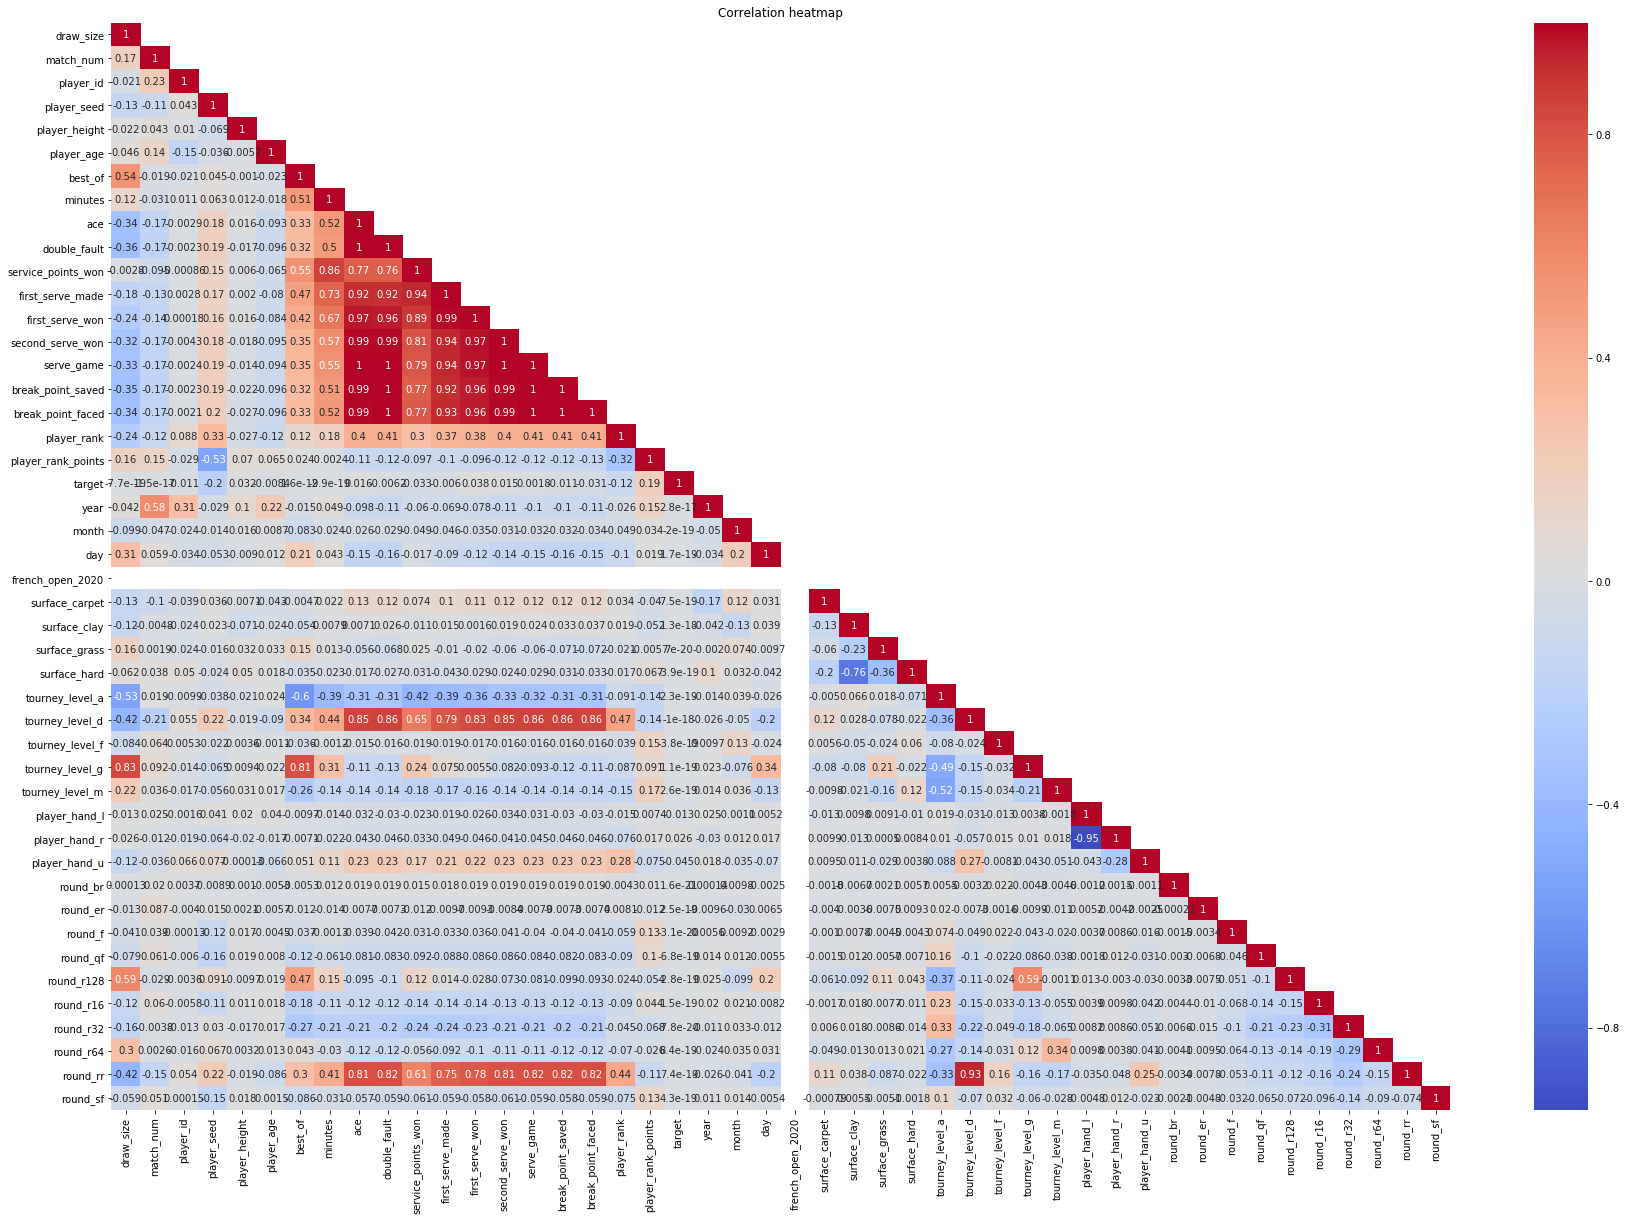

In [126]:
f, ax = plt.subplots(figsize= (30, 20))
lower = atp_corr.where(np.tril(np.ones(atp_corr.shape)).astype(np.bool))
hmap=sns.heatmap(lower,cmap="coolwarm", annot=True)
ax.set_title('Correlation heatmap')
plt.savefig('clean-corr-half.png')

**player_rank_points** is the highest positively correlated variable to the target variabl whereas **player_seed** is the negatively correlated to the target variable.

**Remove french_open_2020**

**Convert the categorical columns to numeric**

In [28]:
#reduced_df = wta_data_nofrench[(wta_data_nofrench['year']== 2018 & 2019)]
#reduced_df.head()

,draw_size,match_num,player_id,player_seed,player_height,player_age,best_of,minutes,ace,double_fault,...,round_br,round_er,round_f,round_qf,round_r128,round_r16,round_r32,round_r64,round_rr,round_sf
56004,32,271,105992,999.0,183.000000,25.653662,3,123.0,9.0,2.0,...,0,0,0,0,0,0,1,0,0,0
56005,32,272,111577,999.0,185.490424,21.229295,3,90.0,5.0,3.0,...,0,0,0,0,0,0,1,0,0,0
56006,32,273,104797,999.0,188.000000,31.318275,3,145.0,7.0,0.0,...,0,0,0,0,0,0,1,0,0,0
56007,32,275,200282,999.0,185.490424,18.872005,3,104.0,9.0,3.0,...,0,0,0,0,0,0,1,0,0,0
56008,32,276,111581,999.0,185.490424,19.975359,3,69.0,5.0,4.0,...,0,0,0,0,0,0,1,0,0,0


**Split data into training and testing sets**

In [127]:
X = atp_data.loc[:, atp_data.columns != 'target']
y = atp_data['target']

**Standardization**

In [128]:
#standardize both training and testing data
sc = StandardScaler()
X_std = sc.fit_transform(X)
X_std_train, X_std_test, y_std_train, y_std_test = train_test_split(X_std, y, test_size=0.3, stratify=y, random_state=SEED)

**Apply the models on the Standardized Data**


**Logistic Regression**

In [129]:
lr = LogisticRegression()
lr_pipe = make_pipeline(lr)
lr_pipe.fit(X_std_train, y_std_train)

y_std_tr_pred = lr_pipe.predict(X_std_train)
y_std_ts_pred = lr_pipe.predict(X_std_test)

print("Accuracy score on train: {}\nAccuracy score on test: {}\n".format(accuracy_score(y_std_train, y_std_tr_pred), 
                                                                         accuracy_score(y_std_test, y_std_ts_pred)))

print("f1 score on train: {}\nf1 score on test: {}\n".format(f1_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                             f1_score(y_std_test, y_std_ts_pred, average='binary')))

print("Precision score on train: {}\nPrecision score on test: {}\n".format(precision_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                           precision_score(y_std_test, y_std_ts_pred, average='binary')))

print("Recall score on train: {}\nRecall score on test: {}\n".format(recall_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                     recall_score(y_std_test, y_std_ts_pred, average='binary')))

C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy score on train: 0.7900325245051469
Accuracy score on test: 0.7852653540226887

f1 score on train: 0.7920246213798601
f1 score on test: 0.7867833652700813

Precision score on train: 0.7845894016494122
Precision score on test: 0.781240357914224

Recall score on train: 0.7996021101573677
Recall score on test: 0.792405591487586



**Random Forest**

In [130]:
rf = RandomForestClassifier()
rf_pipe = make_pipeline(rf)
rf_pipe.fit(X_std_train, y_std_train)

y_std_tr_pred = rf_pipe.predict(X_std_train)
y_std_ts_pred = rf_pipe.predict(X_std_test)

print("Accuracy score on train: {}\nAccuracy score on test: {}\n".format(accuracy_score(y_std_train, y_std_tr_pred), 
                                                                         accuracy_score(y_std_test, y_std_ts_pred)))

print("f1 score on train: {}\nf1 score on test: {}\n".format(f1_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                             f1_score(y_std_test, y_std_ts_pred, average='binary')))

print("Precision score on train: {}\nPrecision score on test: {}\n".format(precision_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                           precision_score(y_std_test, y_std_ts_pred, average='binary')))

print("Recall score on train: {}\nRecall score on test: {}\n".format(recall_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                     recall_score(y_std_test, y_std_ts_pred, average='binary')))

C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy score on train: 0.9898961674732595
Accuracy score on test: 0.7415308384404746

f1 score on train: 0.9898321860799928
f1 score on test: 0.7270223372903296

Precision score on train: 0.9961514081318482
Precision score on test: 0.7702363583309016

Recall score on train: 0.9835926323319027
Recall score on test: 0.6883997496348843



**Bagging classiefier**

In [131]:
bagged_config = dict(n_estimators=10, max_samples=0.6, max_features=0.7, random_state=42, n_jobs=-1)


clb = [lr_pipe, rf_pipe]
clb_names = ['LogisticRegression', 'Random Forest']

for name, cl in zip(clb_names, clb):
    
    bagcl = BaggingClassifier(cl, **bagged_config)
    
    stdsc = StandardScaler()

    #x_ts_sd = stdsc.fit_transform(X_test)

    y_tr_pred = lr_pipe.predict(X_std_train)
    y_ts_pred = lr_pipe.predict(X_std_test)

print("Accuracy score on train: {}\nAccuracy score on test: {}\n".format(accuracy_score(y_std_train, y_std_tr_pred), 
                                                                         accuracy_score(y_std_test, y_std_ts_pred)))

print("f1 score on train: {}\nf1 score on test: {}\n".format(f1_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                             f1_score(y_std_test, y_std_ts_pred, average='binary')))

print("Precision score on train: {}\nPrecision score on test: {}\n".format(precision_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                           precision_score(y_std_test, y_std_ts_pred, average='binary')))

print("Recall score on train: {}\nRecall score on test: {}\n".format(recall_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                     recall_score(y_std_test, y_std_ts_pred, average='binary')))

Accuracy score on train: 0.9898961674732595
Accuracy score on test: 0.7415308384404746

f1 score on train: 0.9898321860799928
f1 score on test: 0.7270223372903296

Precision score on train: 0.9961514081318482
Precision score on test: 0.7702363583309016

Recall score on train: 0.9835926323319027
Recall score on test: 0.6883997496348843



# GridSearchCV

**Logistic Regression**

In [132]:
lr = LogisticRegression(random_state= 42, C = 1, solver='liblinear')

param_grid = {'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

lr_cv = GridSearchCV(lr, param_grid, cv=10)
lr_cv.fit(X_std_train, y_std_train)

y_std_tr_pred = lr_cv.predict(X_std_train)
y_std_ts_pred = lr_cv.predict(X_std_test)

print(lr_cv.best_params_) 
print(lr_cv.best_score_)

C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

{'C': 1.0}
0.7899319332521152


In [133]:
#accuracy score on the training set
accuracy_score(y_std_train, y_std_tr_pred) 

0.7900325245051469

# ANALYSIS

In [136]:
X_20 = atp_french_open_2020.loc[:, atp_french_open_2020.columns != 'target']
y_20 = atp_french_open_2020['target']

In [137]:
X_20_pred = lr_cv.predict(X_20 )

accuracy_score(y_20, X_20_pred)

0.5

In [139]:
X_20_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [140]:
np.unique(X_20_pred)

array([1], dtype=int64)

In [141]:
len(X_20_pred)

254

In [143]:
#add a column to X_20_pred
atp_french_open_2020['predicted_values']=X_20_pred

**Dataset with the predicted column**

In [ ]:
reduced_df_french.to_pickle("C:/Users/JAH/Documents/DSE/DSE2100_ML_project_dataset.pkl")

In [ ]:
reduced_df_french.to_csv("C:/Users/JAH/Documents/DSE/DSE2100_ML_project_dataset.csv")